In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def phi(x, y):
    num = -(x+y) + np.sqrt((x+y+2)**2 + 4*(x+1)*(y+1))
    denom = 2
    return num / denom

# generate silver stepsize schedule of specified length:
def generate_silver_stepsize_sequence(length=1000):
    stepsizes = []

    while len(stepsizes) < length:
        current_sum = np.sum(stepsizes)
        connecting_term = phi(current_sum, current_sum)
        new_terms = [connecting_term] + stepsizes
        stepsizes += new_terms
    return stepsizes[:length]

# Or, generate silver stepsize schedule by recursion
def generate_silver_stepsize_sequence_recursive(order):
    """generate silver stepsize schedule of specified order"""
    if order == 0:
        return [], 0.0
    
    s_prev, sum_prev = generate_silver_stepsize_sequence_recursive(order-1)
    connect = phi(sum_prev, sum_prev)
    new_seq = s_prev + [connect] + s_prev
    return new_seq, 2*sum_prev + connect

# generate anytime stepsize schedule of specified length:
def generate_anytime_schedule(T, c=np.log2(1+np.sqrt(2))):
    """generate new stepsize schedule of length T"""
    sequence = []
    block_sums = []
    j = 1
    
    while len(sequence) < T:
        silver_j, sum_silver = generate_silver_stepsize_sequence_recursive(j)
        len_silver = len(silver_j)
        
        k_j = int(np.floor(2 * 2**(c*j)))
        
        for _ in range(k_j):
            if sequence:
                x = np.sum(sequence)
                y = sum_silver
                connect = phi(x, y)
                sequence.append(connect)
                block_sums.append(connect)

            sequence.extend(silver_j)
            block_sums.extend([sum_silver]*len_silver)
            
            if len(sequence) >= T:
                break
        j += 1
    return sequence[:T]


In [2]:
# This trunk includes all 1-smooth convex functions to be simulated on

def anisotropic_quad(x):
    A = np.diag([0.001, 0.1])
    return x.T @ A @ x

def log_sum_exp_2d(x):
    A = np.array([[1.0, 0.0], [-1.0, 0.0], [0.0, 1.0], [0.0, -1.0]])
    lin = A @ x
    return np.log(np.sum(np.exp(lin)))

def multi_logistic(x):
    """
    f(x) = ∑ log(1 + exp(a_i^T x)), with 3 directions: [1,0], [0,1], [-1,-1]
    """
    A = np.array([[1, 0], [0, 1], [-1, -1]])
    return np.sum(np.log(1 + np.exp(A @ x)))


def softmax_cross_entropy_2d(x):
    """
    f(x) = log(sum exp(a_i^T x)) - a_k^T x
    """
    A = np.array([[2, 0], [0, 1], [-1, -1]])
    k = 1 
    logits = A @ x
    return np.log(np.sum(np.exp(logits))) - logits[k]





# define corresponding gradients

def grad_anisotropic_quad(x):
    A = np.diag([0.001, 0.1])
    return 2 * A @ x


def grad_log_sum_exp_2d(x):
    A = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
    lin = A @ x
    weights = np.exp(lin)
    weights /= np.sum(weights)
    return A.T @ weights

def grad_multi_logistic(x):
    A = np.array([[1, 0], [0, 1], [-1, -1]])
    z = A @ x
    sigmoid = 1 / (1 + np.exp(-z))
    return A.T @ sigmoid

def grad_softmax_cross_entropy_2d(x):
    A = np.array([[2.0, 0.0], [0.0, 1.0], [-1.0, -1.0]])
    k = 1
    logits = A @ x
    exp_logits = np.exp(logits)
    softmax = exp_logits / np.sum(exp_logits)
    grad = A.T @ softmax - A[k]
    return grad





# each element is of the form: (f, grad(f), minima f^*)
function_bank = {
    'anisotropic_quad': (anisotropic_quad, grad_anisotropic_quad, 0.0),
    'log_sum_exp': (log_sum_exp_2d, grad_log_sum_exp_2d, np.log(4)),
    'multi_logistic': (multi_logistic, grad_multi_logistic, 3 * np.log(2)),
    'softmax_cross_entropy': (softmax_cross_entropy_2d, grad_softmax_cross_entropy_2d, None)
}


In [3]:
# This function is to numerically estimate the minima of each funtion, so we can compute teh differences between f_t and f^* after each iteration
def estimate_minimum(func, grad_func, x0, method='L-BFGS-B'):
    """
    estimated the minimal f*
    """
    result = minimize(
        fun=func,
        x0=x0,
        jac=grad_func,
        method=method,
        options={'gtol': 1e-10, 'disp': False, 'maxiter': 1000}
    )
    if not result.success:
        print(f"Warning: minimum estimation failed. Message: {result.message}")
    return result.fun


# This function is used to detect if the minima is missing; if so, estimate the minima
def complete_function_bank_with_minima(function_bank, x0):
    new_bank = {}
    for name, (f, grad, f_star) in function_bank.items():
        if f_star is None:
            print(f"Estimating f* for {name} ...")
            f_star = estimate_minimum(f, grad, x0)
        new_bank[name] = (f, grad, f_star)
    return new_bank

In [4]:
# This function is used to generate the history of 3 types of stepsize schedule

def optimize_with_schedules(func, grad_func, x0, stepsizes, T):
    """
    func: target function f(x)
    grad_func: gradient
    x0: initial point (1D np array)
    stepsizes: dict of name -> stepsize array of length T
    T: number of iterations
    """
    history = {}
    
    for name, seq in stepsizes.items():
        x_t = [x0.copy()]
        f_t = [func(x0)]
        for t in range(T):
            xt = x_t[-1]
            grad = grad_func(xt)
            xt_next = xt - seq[t] * grad
            if np.any(np.isnan(xt_next)) or np.any(np.isinf(xt_next)):
                print(f"{name} diverged at iteration {t}")
                break
            x_t.append(xt_next)
            f_t.append(func(xt_next))
        history[name] = {
            'x': np.array(x_t),
            'f': np.array(f_t)
        }
    
    return history


# This function is used to plot the convergence comparison between 3 types of stepsize schedule

import matplotlib.pyplot as plt
import numpy as np

def plot_convergence(history, f_star, threshold=1e-10, margin_ratio=0.05):
    """
    history: dict of {name: {'f': [f_0, ..., f_T]}}
    f_star: optimal function value
    threshold: cutoff value for deciding useful iterations
    margin_ratio: controls x-axis padding as percentage
    """
    plt.figure(figsize=(8, 5))

    max_useful_t = 0
    y_min, y_max = np.inf, -np.inf

    for name in history:
        f_vals = history[name]['f']
        gap = f_vals - f_star
        useful_idx = np.where(gap > threshold)[0]
        if len(useful_idx) > 0:
            max_useful_t = max(max_useful_t, useful_idx[-1])
        y_min = min(y_min, np.min(gap[gap > 0]))
        y_max = max(y_max, np.max(gap))

    # Apply margin on x-axis
    x_max = int((1 + margin_ratio) * max_useful_t)
    x_max = max(x_max, 10)

    for name in history:
        f_vals = history[name]['f']
        gap = f_vals - f_star
        steps = np.arange(len(gap))
        plt.plot(steps, gap, label=name)

    plt.yscale('log')
    plt.xlim(0, x_max)
    plt.ylim(y_min * 0.8, y_max * 1.2)
    plt.xlabel('Iteration $t$')
    plt.ylabel(r'$f(x_t) - f^*$')
    plt.title('Convergence Comparison of Step Size Schedules')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend()

    ks = np.arange(1, int(np.log2(x_max + 1)) + 1)
    for k in ks:
        vline_t = 2**k - 1
        if vline_t < x_max:
            plt.axvline(vline_t, color='gray', linestyle=':', linewidth=0.8)

    plt.tight_layout()
    plt.show()


In [5]:
# generate 3 types of schedule of length 100

T = 100
x0 = np.array([1, 1])

silver_seq = np.asarray(generate_silver_stepsize_sequence(T))
anytime_seq = np.asarray(generate_anytime_schedule(T))

alpha = 1
constant_seq = alpha*np.repeat(1, T)

stepsizes = {
    'silver': silver_seq,
    'anytime': anytime_seq,
    'constant': constant_seq
}


# estimate minima for each function if they are missing
function_bank = complete_function_bank_with_minima(function_bank, x0)

# choice: 'anisotropic_quad', 'log_sum_exp', 'multi_logistic', 'softmax_cross_entropy'

#f, grad_f, f_star = function_bank['multi_logistic']
#history = optimize_with_schedules(f, grad_f, x0, stepsizes, T)
#plot_convergence(history, f_star)

Estimating f* for softmax_cross_entropy ...


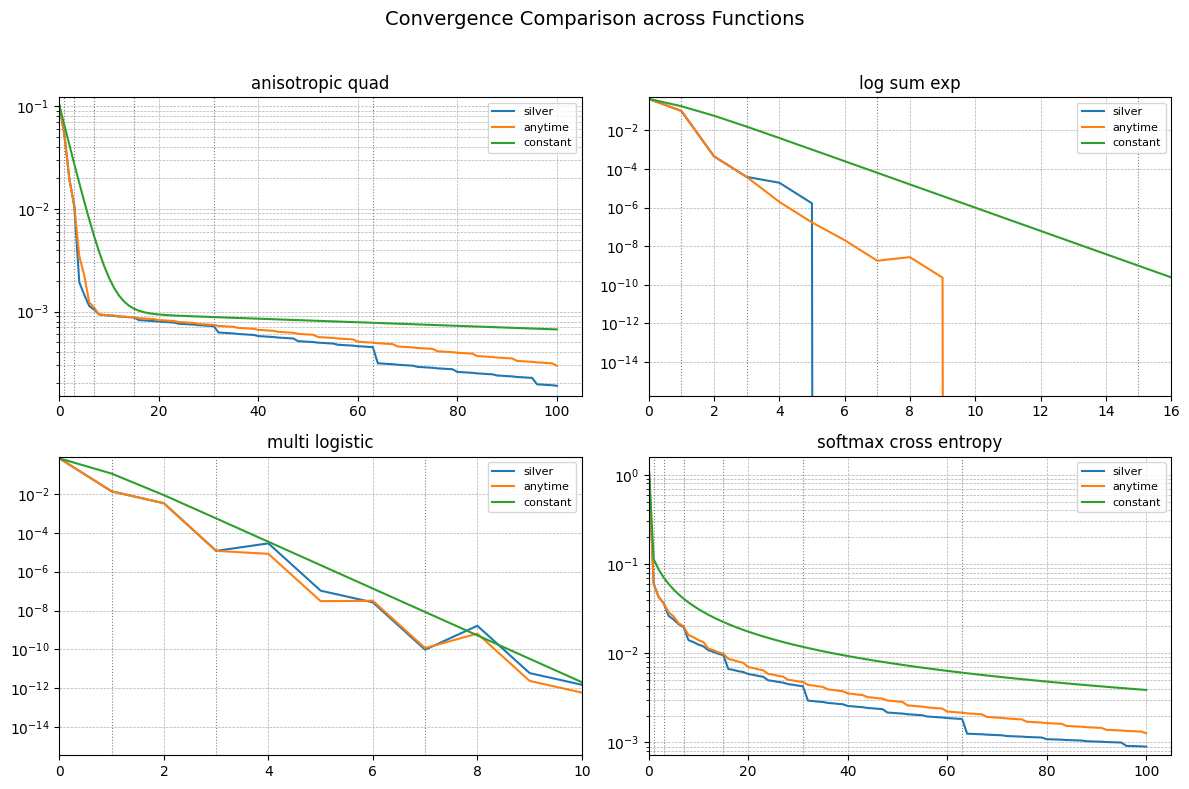

In [6]:
# plot the comparison between convergence rates
selected_funcs = ['anisotropic_quad', 'log_sum_exp', 'multi_logistic', 'softmax_cross_entropy']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, name in enumerate(selected_funcs):
    ax = axes[idx]

    f, grad_f, f_star = function_bank[name]
    if f_star is None:
        f_star = estimate_minimum(f, grad_f, x0)

    history = optimize_with_schedules(f, grad_f, x0, stepsizes, T)

    max_useful_t = 0
    y_min, y_max = np.inf, -np.inf
    for method in history:
        gap = history[method]['f'] - f_star
        useful_idx = np.where(gap > 1e-10)[0]
        if len(useful_idx) > 0:
            max_useful_t = max(max_useful_t, useful_idx[-1])
        y_min = min(y_min, np.min(gap[gap > 0]))
        y_max = max(y_max, np.max(gap))

    x_max = int(1.05 * max_useful_t)
    x_max = max(x_max, 10)

    for method in history:
        gap = history[method]['f'] - f_star
        ax.plot(np.arange(len(gap)), gap, label=method)

    ax.set_yscale('log')
    ax.set_xlim(0, x_max)
    ax.set_ylim(y_min * 0.8, y_max * 1.2)
    ax.set_title(name.replace("_", " "))
    ax.grid(True, which='both', ls='--', lw=0.5)
    ax.legend(fontsize=8)

    ks = np.arange(1, int(np.log2(x_max + 1)) + 1)
    for k in ks:
        t = 2**k - 1
        if t < x_max:
            ax.axvline(t, color='gray', linestyle=':', linewidth=0.8)

for i in range(len(selected_funcs), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Convergence Comparison across Functions', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [7]:
# generate the trajectories and contour maps

def plot_contour_with_paths_ax(ax, f, history, levels=30, title=None):
    all_points = np.vstack([history[name]['x'] for name in history])
    x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
    y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
    pad_x = 0.1 * (x_max - x_min)
    pad_y = 0.1 * (y_max - y_min)
    xlim = (x_min - pad_x, x_max + pad_x)
    ylim = (y_min - pad_y, y_max + pad_y)

    x_vals = np.linspace(xlim[0], xlim[1], 300)
    y_vals = np.linspace(ylim[0], ylim[1], 300)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = f(np.array([X[i, j], Y[i, j]]))

    contour = ax.contourf(X, Y, Z, levels=levels, cmap='RdYlBu_r', alpha=0.7)
    ax.contour(X, Y, Z, levels=levels, colors='k', linewidths=0.3)

    colors = {
        'constant': 'red',
        'silver': 'blue',
        'anytime': 'green'
    }

    for name in history:
        path = history[name]['x']
        ax.plot(path[:, 0], path[:, 1], label=name,
                color=colors.get(name, 'black'), linewidth=2, alpha=0.9)
        sampled = path[::50]
        ax.scatter(sampled[:, 0], sampled[:, 1], color=colors.get(name, 'black'),
                   s=15, alpha=0.7)
        ax.scatter(path[0, 0], path[0, 1], color=colors.get(name, 'black'),
                   marker='o', s=40, alpha=0.8)
        ax.scatter(path[-1, 0], path[-1, 1], color=colors.get(name, 'black'),
                   marker='x', s=50, alpha=0.8)
        ax.text(path[-1, 0], path[-1, 1], f'  {name}', fontsize=9,
                color=colors.get(name, 'black'))

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title or 'Optimization Paths')
    ax.grid(True, linestyle='--', alpha=0.3)

    return contour


def plot_contour_grid(function_bank, x0, stepsizes, T, selection=None, levels=30):
    if selection is None:
        selection = ['anisotropic_quad', 'log_sum_exp', 'multi_logistic', 'softmax_cross_entropy']

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for idx, name in enumerate(selection):
        f, grad_f, f_star = function_bank[name]
        if f_star is None:
            f_star = estimate_minimum(f, grad_f, x0)

        history = optimize_with_schedules(f, grad_f, x0, stepsizes, T)
        plot_contour_with_paths_ax(axes[idx], f, history, levels=levels, title=name.replace('_', ' '))

    for i in range(len(selection), len(axes)):
        fig.delaxes(axes[i])

    fig.suptitle('Contour Plots with Optimization Paths (2x2 Grid)', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



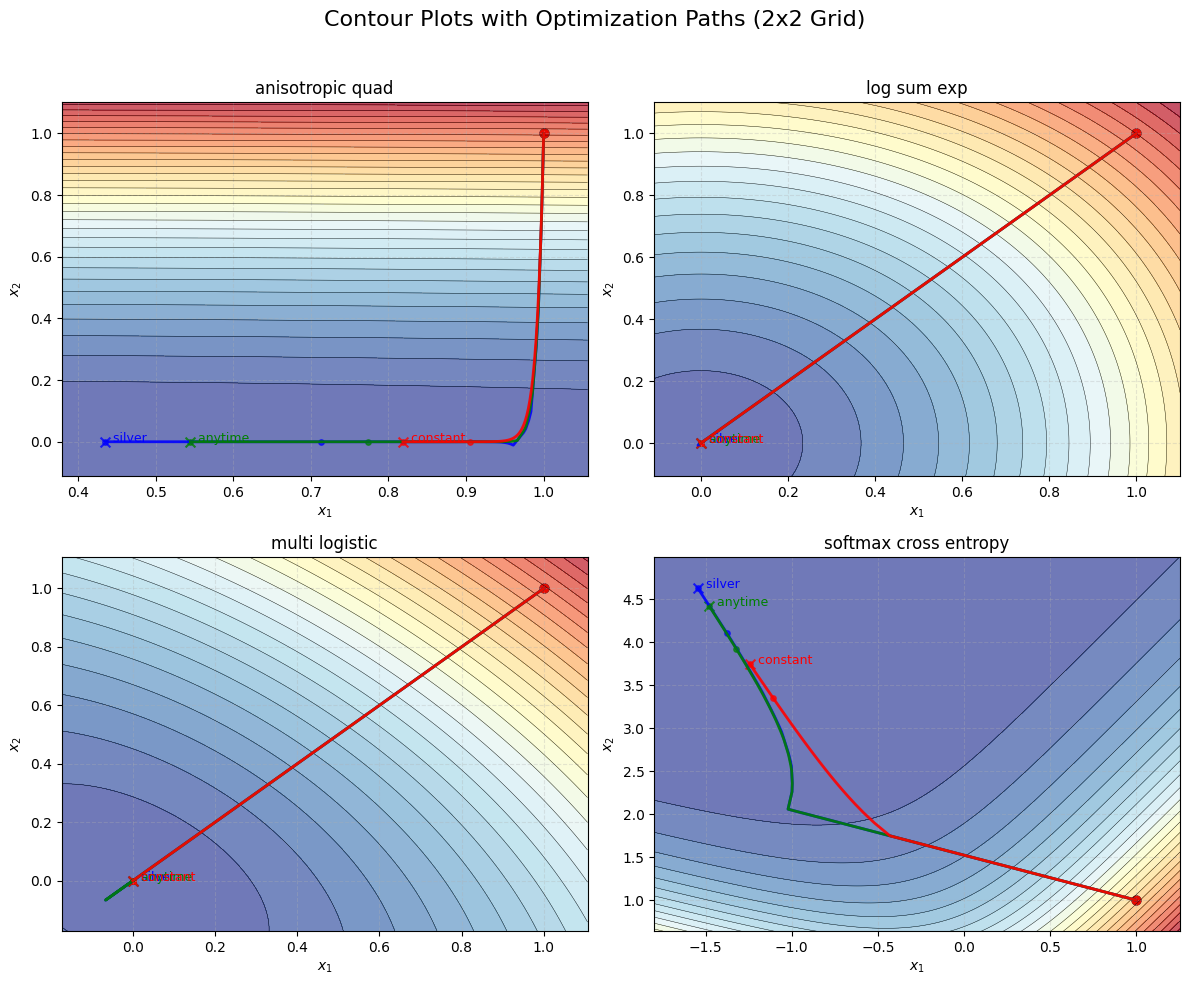

In [8]:
plot_contour_grid(function_bank, x0, stepsizes, T)